### Loading the entire dataset, Scaling data points and splitting data
##### Including removing the inf and nan values in the dataset with the median values of their respective feature columns


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("CICIDS2017_Wednesday_Paper.csv")
df.columns=df.columns.str.strip()
df = df[df['Label'] != 'Heartbleed']

#Replacing the 4 'nan' values in the 'Flow Bytes/s' feature with the median of all values
df["Flow Bytes/s"].replace(np.nan, np.median(df["Flow Bytes/s"].dropna()),inplace=True)
#There are 30 and 34 inifinite values in the 'Flow Bytes/s' and ' Flow Packets/s', respectively.
df.replace(np.inf,np.nan,inplace=True) #We first change inf values to nan values since I find them easier to delete
df["Flow Bytes/s"].replace(np.nan, np.max(df["Flow Bytes/s"].dropna()) ,inplace=True) #Then we are changing them with the max value in the column
df["Flow Packets/s"].replace(np.nan, np.max(df["Flow Packets/s"].dropna()) ,inplace=True)
df.replace(["BENIGN","DoS Hulk","DoS GoldenEye","DoS slowloris","DoS Slowhttptest"],[0,1,2,3,4],inplace=True)

X = MinMaxScaler().fit_transform(df.drop(['Label'],axis=1))
y=df["Label"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

C:\Users\dyari\AppData\Local\Temp\ipykernel_8396\3885227182.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Flow Bytes/s"].replace(np.nan, np.median(df["Flow Bytes/s"].dropna()),inplace=True)
C:\Users\dyari\AppData\Local\Temp\ipykernel_8396\3885227182.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

### Training the MLP model

In [5]:
from sklearn.neural_network import MLPClassifier
import time

clf = MLPClassifier(hidden_layer_sizes=(100,200,250),
                    max_iter=50,solver="adam",
                    verbose=True,activation='relu',
                    learning_rate_init=0.01)

start_time = time.time()
# Fit data onto the model
clf.fit(X_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time

Iteration 1, loss = 0.04269620
Iteration 2, loss = 0.02345256
Iteration 3, loss = 0.02144944
Iteration 4, loss = 0.01814244
Iteration 5, loss = 0.01764739
Iteration 6, loss = 0.01734927
Iteration 7, loss = 0.01832317
Iteration 8, loss = 0.01713493
Iteration 9, loss = 0.01630693
Iteration 10, loss = 0.01596410
Iteration 11, loss = 0.01639828
Iteration 12, loss = 0.01620302
Iteration 13, loss = 0.01670902
Iteration 14, loss = 0.01610364
Iteration 15, loss = 0.01650897
Iteration 16, loss = 0.01567254
Iteration 17, loss = 0.01621127
Iteration 18, loss = 0.01594185
Iteration 19, loss = 0.01515082
Iteration 20, loss = 0.01616484
Iteration 21, loss = 0.01568058
Iteration 22, loss = 0.01545581
Iteration 23, loss = 0.01548008
Iteration 24, loss = 0.01864355
Iteration 25, loss = 0.01633867
Iteration 26, loss = 0.01589326
Iteration 27, loss = 0.01562290
Iteration 28, loss = 0.01551644
Iteration 29, loss = 0.01551813
Iteration 30, loss = 0.01598999
Training loss did not improve more than tol=0.000

### Predictions BEFORE sample modification

Accuracy: 0.996571362576603
---------------------------------------------------------


array([[87657,   356,    20,     3,    35],
       [    7, 46211,     0,     0,     0],
       [    0,    11,  2033,     0,     2],
       [    5,     1,     0,  1087,    21],
       [    7,     2,     0,     5,  1076]], dtype=int64)

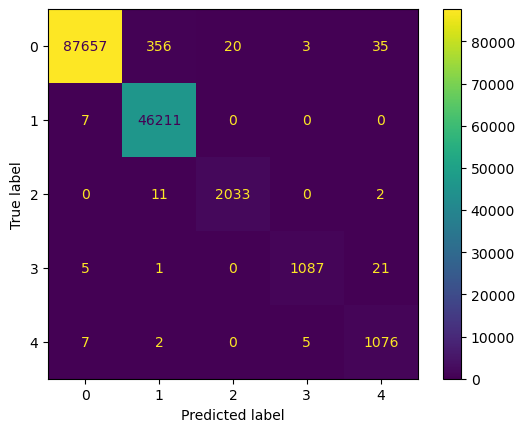

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred=clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("---------------------------------------------------------")

BeforePerturbation = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
BeforePerturbation.confusion_matrix

### Sample modification - Both Benign and Malicious Shuffle

In [9]:
import random

#Identify the unique 'Flow IAT Mean' values of all classes
unique_values = df['Flow IAT Mean'].unique()

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        X_copy.loc[idx, feature] = random.choice(unique_values)

    return X_copy, y_copy


X_evasive3, y_evasive3 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification - Both Benign and Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.6357704328744974


array([[88066,     1,     4,     0,     0],
       [46203,    11,     4,     0,     0],
       [ 2044,     0,     2,     0,     0],
       [ 1114,     0,     0,     0,     0],
       [ 1090,     0,     0,     0,     0]], dtype=int64)

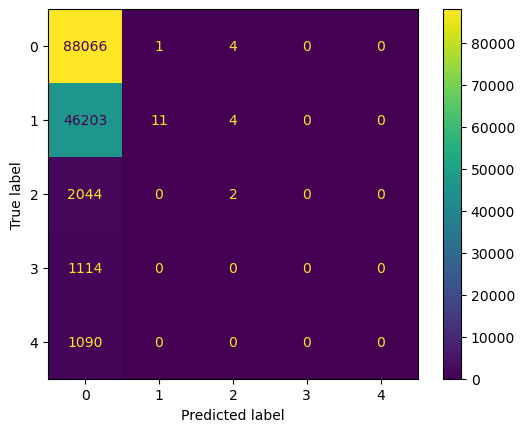

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred3_evasive = clf.predict(X_evasive3)
print("Accuracy:", accuracy_score(y_evasive3,y_pred3_evasive))

Perturb03=ConfusionMatrixDisplay.from_predictions(y_evasive3, y_pred3_evasive)
Perturb03.confusion_matrix